# Import and settings

In [1]:
%load_ext autoreload
%autoreload 2

import os, re, gc, joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.colors import ListedColormap
import seaborn as sn
import plotnine as pln
import anndata
import scanpy as sc
import sctk as sk

rcParams["pdf.fonttype"] = 42
rcParams["ps.fonttype"] = 42
expr_cmap = sk.expression_colormap()
np.set_printoptions(linewidth=150)

import numpy_groupies as npg
from sklearn.preprocessing import minmax_scale
from plotnine import ggplot, aes

/home/ubuntu/miniconda/envs/pyscenic/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.


In [2]:
import loompy as lp

In [3]:
import glob

# Load data

## h5ad

In [18]:
pooled_MS_obs = sc.read(
    "../20200806_organoid_integration_comparison/h5ad/pooled_mesenchymal.processed.h5ad"
).obs

/home/ubuntu/miniconda/envs/pyscenic/lib/python3.8/site-packages/anndata/compat/__init__.py:158: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
/home/ubuntu/miniconda/envs/pyscenic/lib/python3.8/site-packages/anndata/compat/__init__.py:158: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.


In [16]:
fetal_ad = sc.read("../data/h5ad/fetal_skin.norm.maternal_removed.20210611.h5ad")

Only considering the two last: ['.20210611', '.h5ad'].
Only considering the two last: ['.20210611', '.h5ad'].


In [17]:
organoid_ad = sc.read("../20200427_organoid_integration/organoid.cellxgene.h5ad")

### Create pooled MS loom

In [19]:
fsk_MS_ad0 = fetal_ad[
    fetal_ad.obs_names.isin(pd.Series(pooled_MS_obs.index).str.replace("-fetal_skin", ""))
].copy()

/home/ubuntu/miniconda/envs/pyscenic/lib/python3.8/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


In [20]:
org_MS_ad0 = organoid_ad[
    organoid_ad.obs_names.isin(pd.Series(pooled_MS_obs.index).str.replace("-organoid", ""))
].copy()

In [21]:
fsk_MS_ad0.n_obs + org_MS_ad0.n_obs

5895

In [22]:
pooled_MS_obs.shape

(6213, 24)

In [23]:
pooled_MS_ad = fsk_MS_ad0.concatenate(
    org_MS_ad0, join="outer", batch_key="dataset", batch_categories=["fetal_skin", "organoid"]
)

/home/ubuntu/miniconda/envs/pyscenic/lib/python3.8/site-packages/anndata/_core/merge.py:891: UserWarning: Only some AnnData objects have `.raw` attribute, not concatenating `.raw` attributes.


In [24]:
pooled_MS_ad.obs = pooled_MS_obs[pooled_MS_obs.index.isin(pooled_MS_ad.obs_names)].copy()

In [25]:
pooled_MS_ad0 = sk.restore_adata(pooled_MS_ad, restore_type="count", use_raw=False)

In [45]:
lp.create(
    "pooled_MS.count.loom",
    pooled_MS_ad0.X.transpose(),
    row_attrs={"Gene": pooled_MS_ad0.var_names.values},
    col_attrs={
        "CellID": pooled_MS_ad0.obs_names.values,
        "nGene": np.array((pooled_MS_ad0.X > 0).sum(axis=1)).flatten(),
        "nUMI": np.array(pooled_MS_ad0.X.sum(axis=1)).flatten(),
        "joint_annot": pooled_MS_ad0.obs["joint_annot"].astype(str).values,
    },
)

### Clean up

In [11]:
del fetal_ad, organoid_ad

## other data

In [4]:
f_tfs = "../data/db/hs_hgnc_curated_tfs.txt"

In [5]:
f_db_glob = "../data/db/hg38__*.feather"
f_db_names = " ".join(glob.glob(f_db_glob))
f_motif_path = "../data/db/motifs-v9-nr.hgnc-m0.001-o0.0.tbl"

In [6]:
f_db_names

'../data/db/hg38__refseq-r80__500bp_up_and_100bp_down_tss.mc9nr.feather ../data/db/hg38__refseq-r80__10kb_up_and_down_tss.mc9nr.feather'

# Run GRN

In [7]:
!which pyscenic

/usr/local/bin/pyscenic


In [9]:
!/home/ubuntu/miniconda/envs/pyscenic/bin/pyscenic grn 'pooled_MS.count.loom' {f_tfs} -o pooled_MS.adj.csv --num_workers 5


2021-12-22 11:51:47,849 - pyscenic.cli.pyscenic - INFO - Loading expression matrix.

2021-12-22 11:51:51,847 - pyscenic.cli.pyscenic - INFO - Inferring regulatory networks.
preparing dask client
parsing input
creating dask graph
5 partitions
computing dask graph
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:42312 remote=tcp://127.0.0.1:34315>
distributed.comm.tcp - WARNING - Closing dangling stream in <TCP  local=tcp://127.0.0.1:42314 remote=tcp://127.0.0.1:34315>
not shutting down client, client was created externally
finished

2021-12-22 16:24:37,087 - pyscenic.cli.pyscenic - INFO - Writing results to file.


In [5]:
ms_adjacencies = pd.read_csv("pooled_MS.adj.csv", index_col=False)

In [11]:
ms_adjacencies.head()

,TF,target,importance
0,YBX1,RPLP1,187.732347
1,JUNB,FOS,178.371823
2,MXD3,HMGN2,174.555600
3,YBX1,RPS5,173.565666
4,YBX1,RPS2,172.967155


In [12]:
!/home/ubuntu/miniconda/envs/pyscenic/bin/pyscenic ctx 'pooled_MS.adj.csv' \
    {f_db_names} \
    --annotations_fname {f_motif_path} \
    --expression_mtx_fname 'pooled_MS.count.loom' \
    --output pooled_MS.reg.csv \
    --mask_dropouts \
    --num_workers 5


2021-12-22 18:04:31,078 - pyscenic.cli.pyscenic - INFO - Creating modules.

2021-12-22 18:04:33,510 - pyscenic.cli.pyscenic - INFO - Loading expression matrix.

2021-12-22 18:04:38,340 - pyscenic.utils - INFO - Calculating Pearson correlations.

2021-12-22 18:04:39,702 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [True].

2021-12-22 18:05:09,628 - pyscenic.utils - INFO - Creating modules.

2021-12-22 18:07:48,714 - pyscenic.cli.pyscenic - IN

In [26]:
nGenesDetectedPerCell = pd.DataFrame(np.sum(pooled_MS_ad0.X > 0, axis=1))
percentiles = nGenesDetectedPerCell.quantile([0.01, 0.05, 0.10, 0.50, 1])
print(percentiles)

            0
0.01   691.94
0.05   951.00
0.10  1156.00
0.50  2157.00
1.00  5406.00


/home/ubuntu/miniconda/envs/pyscenic/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


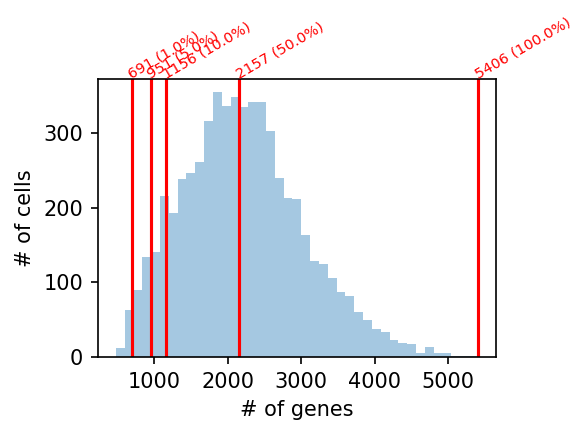

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3), dpi=150)
sn.distplot(nGenesDetectedPerCell, norm_hist=False, kde=False, bins="fd")
for i, x in enumerate(percentiles[0]):
    fig.gca().axvline(x=x, ymin=0, ymax=1, color="red")
    ax.text(
        x=x,
        y=ax.get_ylim()[1],
        s=f"{int(x)} ({percentiles.index.values[i]*100}%)",
        color="red",
        rotation=30,
        size="x-small",
        rotation_mode="anchor",
    )
ax.set_xlabel("# of genes")
ax.set_ylabel("# of cells")
fig.tight_layout()

In [28]:
!/home/ubuntu/miniconda/envs/pyscenic/bin/pyscenic aucell \
    'pooled_MS.count.loom' \
    'pooled_MS.reg.csv' \
    --output 'pooled_MS.pyscenic_output.loom' \
    --num_workers 5


2021-12-22 22:29:48,899 - pyscenic.cli.pyscenic - INFO - Loading expression matrix.

2021-12-22 22:29:52,232 - pyscenic.cli.pyscenic - INFO - Loading gene signatures.
Create regulons from a dataframe of enriched features.
Additional columns saved: []

2021-12-22 22:30:29,277 - pyscenic.cli.pyscenic - INFO - Calculating cellular enrichment.

2021-12-22 22:30:56,886 - pyscenic.cli.pyscenic - INFO - Writing results to file.


# Further analysis

In [4]:
import json, zlib, base64

from pyscenic.rss import regulon_specificity_scores
from pyscenic.utils import modules_from_adjacencies
from pyscenic.plotting import plot_rss
from adjustText import adjust_text
from pyscenic.binarization import binarize

import matplotlib as mpl
import seaborn as sns

In [56]:
def palplot(pal, names, colors=None, size=1, fontsize=10):
    n = len(pal)
    f, ax = plt.subplots(1, 1, figsize=(n * size, 0.5 * size))
    ax.imshow(
        np.arange(n).reshape(1, n),
        cmap=mpl.colors.ListedColormap(list(pal)),
        interpolation="nearest",
        aspect="auto",
    )
    ax.set_xticks(np.arange(n) - 0.5)
    ax.set_yticks([-0.5, 0.5])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    colors = n * ["k"] if colors is None else colors
    for idx, (name, color) in enumerate(zip(names, colors)):
        ax.text(
            0.0 + idx,
            0.0,
            name,
            color=color,
            horizontalalignment="center",
            verticalalignment="center",
            fontsize=fontsize,
        )
    return f

In [9]:
lf = lp.connect("pooled_MS.pyscenic_output.loom", mode="r+", validate=False)

In [10]:
pooled_MS_auc_mtx = pd.DataFrame(lf.ca.RegulonsAUC, index=lf.ca.CellID)

In [11]:
exprMat = pd.DataFrame(lf[:, :], index=lf.ra.Gene, columns=lf.ca.CellID).T

In [12]:
lf.close()

In [34]:
import umap

In [35]:
runUmap = umap.UMAP(n_neighbors=10, min_dist=0.4, metric="correlation").fit_transform
pooled_MS_dr_umap = runUmap(pooled_MS_auc_mtx)
pd.DataFrame(pooled_MS_dr_umap, columns=["X", "Y"], index=pooled_MS_auc_mtx.index).to_csv(
    "pooled_MS.scenic_umap.txt", sep="\t"
)

In [36]:
lf = lp.connect("pooled_MS.pyscenic_output.loom", mode="r+", validate=False)
pooled_MS_meta = json.loads(zlib.decompress(base64.b64decode(lf.attrs.MetaData)))
pooled_MS_regulons = lf.ra.Regulons
lf.close()

In [37]:
pooled_MS_auc_mtx.columns = pooled_MS_auc_mtx.columns.str.replace("\(", "_(")

In [38]:
pooled_MS_regulons.dtype.names = tuple(
    [x.replace("(", "_(") for x in pooled_MS_regulons.dtype.names]
)

In [39]:
pooled_MS_rt = pooled_MS_meta["regulonThresholds"]
for i, x in enumerate(pooled_MS_rt):
    tmp = x.get("regulon").replace("(", "_(")
    x.update({"regulon": tmp})

/home/ubuntu/miniconda/envs/pyscenic/lib/python3.8/site-packages/anndata/_core/anndata.py:1192: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
... storing 'gene_ids-fetal_skin' as categorical
... storing 'mito-fetal_skin' as categorical
... storing 'ribo-fetal_skin' as categorical
... storing 'hb-fetal_skin' as categorical
... storing 'gene_ids-organoid' as categorical
... storing 'highly_variable-organoid' as categorical


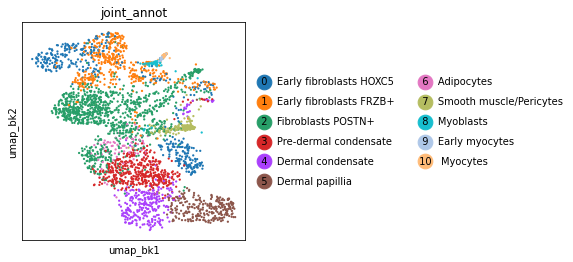

In [40]:
sk.plot_embedding(pooled_MS_ad, basis="umap_bk", groupby="joint_annot");

In [41]:
pooled_MS_ad.obsm["X_umap_dr"] = pooled_MS_dr_umap

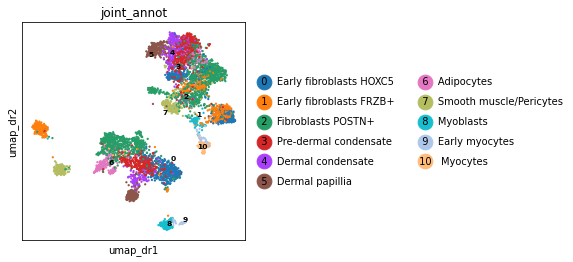

In [42]:
sk.plot_embedding(pooled_MS_ad, basis="umap_dr", groupby="joint_annot");

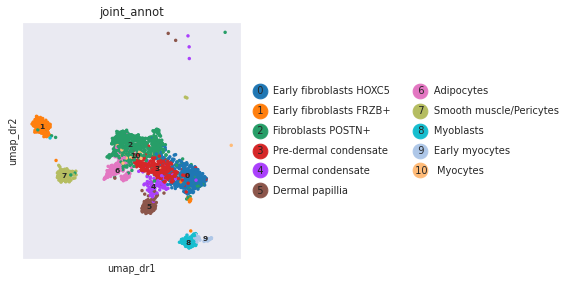

In [75]:
sk.plot_embedding(
    pooled_MS_ad[pooled_MS_ad.obs.dataset == "fetal_skin"],
    basis="umap_dr",
    groupby="joint_annot",
    figsize=(8, 4),
);

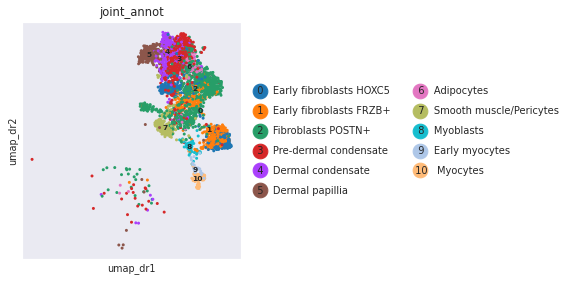

In [76]:
sk.plot_embedding(
    pooled_MS_ad[pooled_MS_ad.obs.dataset == "organoid"],
    basis="umap_dr",
    groupby="joint_annot",
    figsize=(8, 4),
);

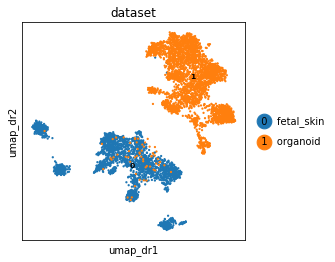

In [43]:
sk.plot_embedding(pooled_MS_ad, basis="umap_dr", groupby="dataset");

## By cell type

In [44]:
pooled_MS_rss_cellType = regulon_specificity_scores(pooled_MS_auc_mtx, pooled_MS_ad.obs.joint_annot)

In [68]:
pooled_MS_rss_cellType.iloc[:, 0:5]

,ALX3_(+),ALX4_(+),ARID3A_(+),ARNT_(+),ARNT2_(+)
Fibroblasts POSTN+,0.411378,0.310573,0.357361,0.386680,0.237685
Myoblasts,0.211699,0.187416,0.206690,0.193928,0.181817
Early fibroblasts HOXC5,0.305314,0.257083,0.312852,0.317565,0.230439
Early myocytes,0.183995,0.175050,0.190505,0.180048,0.180200
Smooth muscle/Pericytes,0.236326,0.213442,0.240645,0.226183,0.195341
Pre-dermal condensate,0.297868,0.273801,0.295859,0.305850,0.215770
Early fibroblasts FRZB+,0.269464,0.234038,0.256698,0.271599,0.243959
Myocytes,0.191571,0.180696,0.206466,0.180456,0.174365
Dermal papillia,0.266969,0.407816,0.237220,0.266197,0.207433
Adipocytes,0.224773,0.194855,0.217435,0.225034,0.204075


In [46]:
pooled_MS_ad.obs.joint_annot.cat.categories.size

11

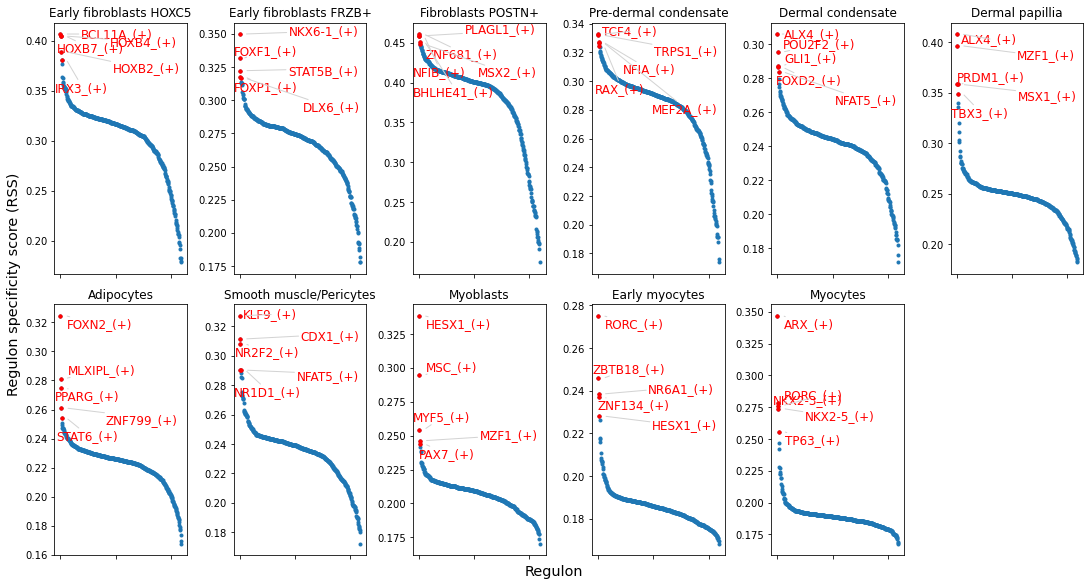

In [47]:
fig = plt.figure(figsize=(15, 8))
for i, c in enumerate(pooled_MS_ad.obs.joint_annot.cat.categories):
    num = i + 1
    x = pooled_MS_rss_cellType.T[c]
    ax = fig.add_subplot(2, 6, num)
    plot_rss(pooled_MS_rss_cellType, c, top_n=5, max_n=None, ax=ax)
    ax.set_ylim(x.min() - (x.max() - x.min()) * 0.05, x.max() + (x.max() - x.min()) * 0.05)
    for t in ax.texts:
        t.set_fontsize(12)
    ax.set_ylabel("")
    ax.set_xlabel("")
    adjust_text(
        ax.texts,
        autoalign="xy",
        ha="right",
        va="bottom",
        arrowprops=dict(arrowstyle="-", color="lightgrey"),
        precision=0.001,
    )

fig.text(0.5, 0.0, "Regulon", ha="center", va="center", size="x-large")
fig.text(
    0.00,
    0.5,
    "Regulon specificity score (RSS)",
    ha="center",
    va="center",
    rotation="vertical",
    size="x-large",
)
plt.tight_layout()
plt.rcParams.update(
    {
        "figure.autolayout": True,
        "figure.titlesize": "large",
        "axes.labelsize": "medium",
        "axes.titlesize": "large",
        "xtick.labelsize": "medium",
        "ytick.labelsize": "medium",
    }
)

In [13]:
ms_modules = list(modules_from_adjacencies(ms_adjacencies, exprMat))


2022-02-28 13:08:05,378 - pyscenic.utils - INFO - Calculating Pearson correlations.

2022-02-28 13:08:06,662 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [False].

2022-02-28 13:09:03,007 - pyscenic.utils - INFO - Creating modules.


In [ ]:
ms_modules[0].gene2weight

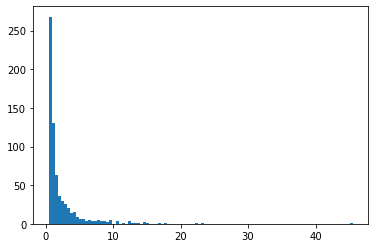

In [44]:
plt.hist(
    np.array([list(m.gene2weight.values()) for m in ms_modules if m.name == "Regulon for ALX4"][0]),
    100,
);

In [50]:
[g for g, v in list([m for m in ms_modules if m.name == "Regulon for ALX4"])[0].gene2weight.items() if v >= 10]

['CSMD2',
 'JAG1',
 'MCC',
 'TPD52',
 'SOX18',
 'PCSK2',
 'PAPPA2',
 'EDNRA',
 'GLIS1',
 'SOX2',
 'ALPL',
 'RSPO3',
 'PTCH1',
 'MTURN',
 'SCUBE3',
 'LAMC3',
 'SLC27A6',
 'WNT5A',
 'NDP']

In [20]:
len(ms_modules[0].genes)

1677

In [48]:
pooled_MS_topreg = []
for i, c in enumerate(pooled_MS_ad.obs.joint_annot.cat.categories):
    pooled_MS_topreg.extend(
        list(pooled_MS_rss_cellType.T[c].sort_values(ascending=False)[:5].index)
    )
pooled_MS_topreg = list(set(pooled_MS_topreg))

In [49]:
pooled_MS_auc_mtx_Z = pd.DataFrame(index=pooled_MS_auc_mtx.index)
for col in list(pooled_MS_auc_mtx.columns):
    pooled_MS_auc_mtx_Z[col] = (
        pooled_MS_auc_mtx[col] - pooled_MS_auc_mtx[col].mean()
    ) / pooled_MS_auc_mtx[col].std(ddof=0)

In [50]:
colors = sns.color_palette("bright", n_colors=pooled_MS_ad.obs.joint_annot.cat.categories.size)
colorsd = dict(zip(pooled_MS_ad.obs.joint_annot.cat.categories, colors))
colormap = [colorsd[x] for x in pooled_MS_ad.obs.joint_annot]

/home/ubuntu/miniconda/envs/pyscenic/lib/python3.8/site-packages/seaborn/matrix.py:659: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.


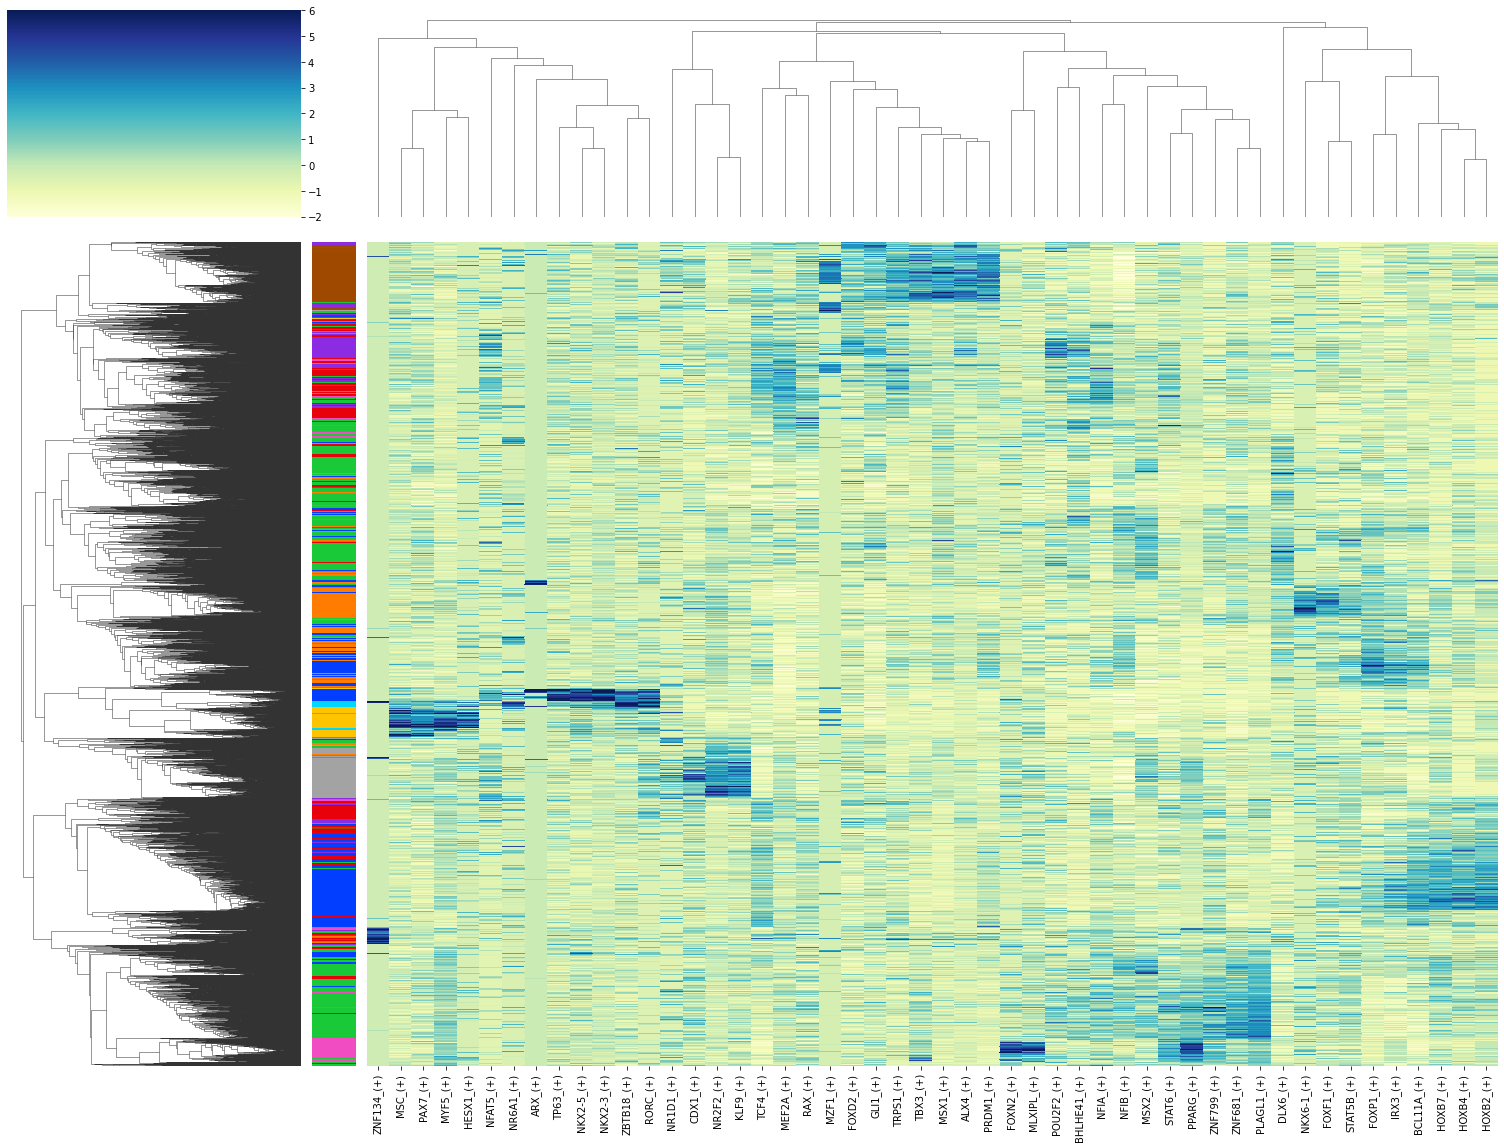

In [51]:
g = sns.clustermap(
    pooled_MS_auc_mtx_Z[pooled_MS_topreg],
    square=False,
    linecolor="gray",
    yticklabels=False,
    xticklabels=True,
    vmin=-2,
    vmax=6,
    row_colors=colormap,
    method="average",
    metric="cosine",
    cmap="YlGnBu",
    figsize=(21, 16),
)
g.cax.set_visible(True)
g.ax_heatmap.set_ylabel("")
g.ax_heatmap.set_xlabel("");

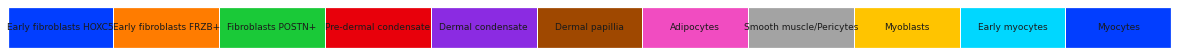

In [58]:
fig = palplot(colors, pooled_MS_ad.obs.joint_annot.cat.categories, size=1.5, fontsize=9)

## By data source

In [59]:
pooled_MS_rss_dataset = regulon_specificity_scores(pooled_MS_auc_mtx, pooled_MS_ad.obs.dataset)

In [60]:
pooled_MS_rss_dataset.iloc[0:5, 0:5]

,ALX3_(+),ALX4_(+),ARID3A_(+),ARNT_(+),ARNT2_(+)
fetal_skin,0.456014,0.365086,0.414961,0.482052,0.293841
organoid,0.603975,0.506396,0.511003,0.534043,0.242046


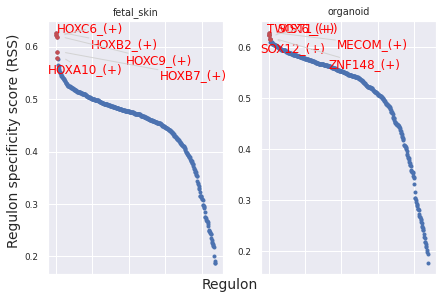

In [69]:
fig = plt.figure(figsize=(6, 4))
for i, c in enumerate(pooled_MS_ad.obs.dataset.cat.categories):
    num = i + 1
    x = pooled_MS_rss_dataset.T[c]
    ax = fig.add_subplot(1, 2, num)
    plot_rss(pooled_MS_rss_dataset, c, top_n=5, max_n=None, ax=ax)
    ax.set_ylim(x.min() - (x.max() - x.min()) * 0.05, x.max() + (x.max() - x.min()) * 0.05)
    for t in ax.texts:
        t.set_fontsize(12)
    ax.set_ylabel("")
    ax.set_xlabel("")
    adjust_text(
        ax.texts,
        autoalign="xy",
        ha="right",
        va="bottom",
        arrowprops=dict(arrowstyle="-", color="lightgrey"),
        precision=0.001,
    )

fig.text(0.5, 0.0, "Regulon", ha="center", va="center", size="x-large")
fig.text(
    0.00,
    0.5,
    "Regulon specificity score (RSS)",
    ha="center",
    va="center",
    rotation="vertical",
    size="x-large",
)
plt.tight_layout()
plt.rcParams.update(
    {
        "figure.autolayout": True,
        "figure.titlesize": "large",
        "axes.labelsize": "medium",
        "axes.titlesize": "large",
        "xtick.labelsize": "medium",
        "ytick.labelsize": "medium",
    }
)

In [62]:
pooled_MS_topreg = []
for i, c in enumerate(pooled_MS_ad.obs.dataset.cat.categories):
    pooled_MS_topreg.extend(list(pooled_MS_rss_dataset.T[c].sort_values(ascending=False)[:5].index))
pooled_MS_topreg = list(set(pooled_MS_topreg))

In [63]:
pooled_MS_auc_mtx_Z = pd.DataFrame(index=pooled_MS_auc_mtx.index)
for col in list(pooled_MS_auc_mtx.columns):
    pooled_MS_auc_mtx_Z[col] = (
        pooled_MS_auc_mtx[col] - pooled_MS_auc_mtx[col].mean()
    ) / pooled_MS_auc_mtx[col].std(ddof=0)

In [64]:
colors = sns.color_palette("bright", n_colors=pooled_MS_ad.obs.dataset.cat.categories.size)
colorsd = dict(zip(pooled_MS_ad.obs.dataset.cat.categories, colors))
colormap = [colorsd[x] for x in pooled_MS_ad.obs.dataset]

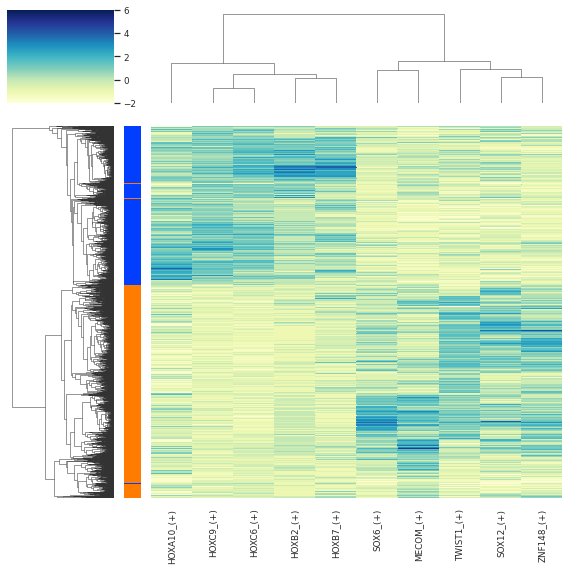

In [67]:
g = sns.clustermap(
    pooled_MS_auc_mtx_Z[pooled_MS_topreg],
    square=False,
    linecolor="gray",
    yticklabels=False,
    xticklabels=True,
    vmin=-2,
    vmax=6,
    row_colors=colormap,
    method="average",
    metric="cosine",
    cmap="YlGnBu",
    figsize=(8, 8),
)
g.cax.set_visible(True)
g.ax_heatmap.set_ylabel("")
g.ax_heatmap.set_xlabel("");

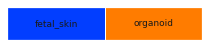

In [66]:
sns.set(font_scale=0.8)
fig = palplot(colors, pooled_MS_ad.obs.dataset.cat.categories, size=1.5, fontsize=9)

## By cell type and data source

In [78]:
pooled_MS_ad.obs["source_joint_annot"] = (
    pooled_MS_ad.obs.dataset.astype(str) + "_" + pooled_MS_ad.obs.joint_annot.astype(str)
)
pooled_MS_ad.obs["source_joint_annot"] = pooled_MS_ad.obs["source_joint_annot"].astype("category")

In [79]:
pooled_MS_rss_sourceCellType = regulon_specificity_scores(
    pooled_MS_auc_mtx, pooled_MS_ad.obs.source_joint_annot
)

In [80]:
pooled_MS_rss_sourceCellType.iloc[:, 0:5]

,ALX3_(+),ALX4_(+),ARID3A_(+),ARNT_(+),ARNT2_(+)
fetal_skin_Fibroblasts POSTN+,0.276052,0.226157,0.258397,0.290521,0.228678
fetal_skin_Myoblasts,0.196891,0.180249,0.190454,0.184838,0.179813
fetal_skin_Early fibroblasts HOXC5,0.251375,0.213201,0.257107,0.265235,0.225496
fetal_skin_Early myocytes,0.176361,0.171825,0.175789,0.173237,0.174021
fetal_skin_Smooth muscle/Pericytes,0.202728,0.197601,0.217380,0.200623,0.182313
fetal_skin_Pre-dermal condensate,0.219896,0.214620,0.225705,0.230894,0.206713
fetal_skin_Early fibroblasts FRZB+,0.207211,0.188471,0.201257,0.224000,0.241257
fetal_skin_Myocytes,0.172204,0.169496,0.169910,0.171453,0.167445
fetal_skin_Dermal papillia,0.210578,0.281607,0.199283,0.214945,0.200083
fetal_skin_Adipocytes,0.205891,0.186166,0.197264,0.209328,0.195315


In [81]:
pooled_MS_ad.obs.source_joint_annot.cat.categories.size

22

In [84]:
pooled_MS_ad.obs.source_joint_annot.value_counts().sort_index()

fetal_skin_Adipocytes                  194
fetal_skin_Dermal condensate            98
fetal_skin_Dermal papillia             176
fetal_skin_Early fibroblasts FRZB+     213
fetal_skin_Early fibroblasts HOXC5     520
fetal_skin_Early myocytes               39
fetal_skin_Fibroblasts POSTN+          684
fetal_skin_Myoblasts                   134
fetal_skin_Myocytes                     15
fetal_skin_Pre-dermal condensate       278
fetal_skin_Smooth muscle/Pericytes     179
organoid_Adipocytes                     85
organoid_Dermal condensate             290
organoid_Dermal papillia               264
organoid_Early fibroblasts FRZB+       423
organoid_Early fibroblasts HOXC5       425
organoid_Early myocytes                 36
organoid_Fibroblasts POSTN+           1040
organoid_Myoblasts                      71
organoid_Myocytes                       79
organoid_Pre-dermal condensate         454
organoid_Smooth muscle/Pericytes       198
Name: source_joint_annot, dtype: int64

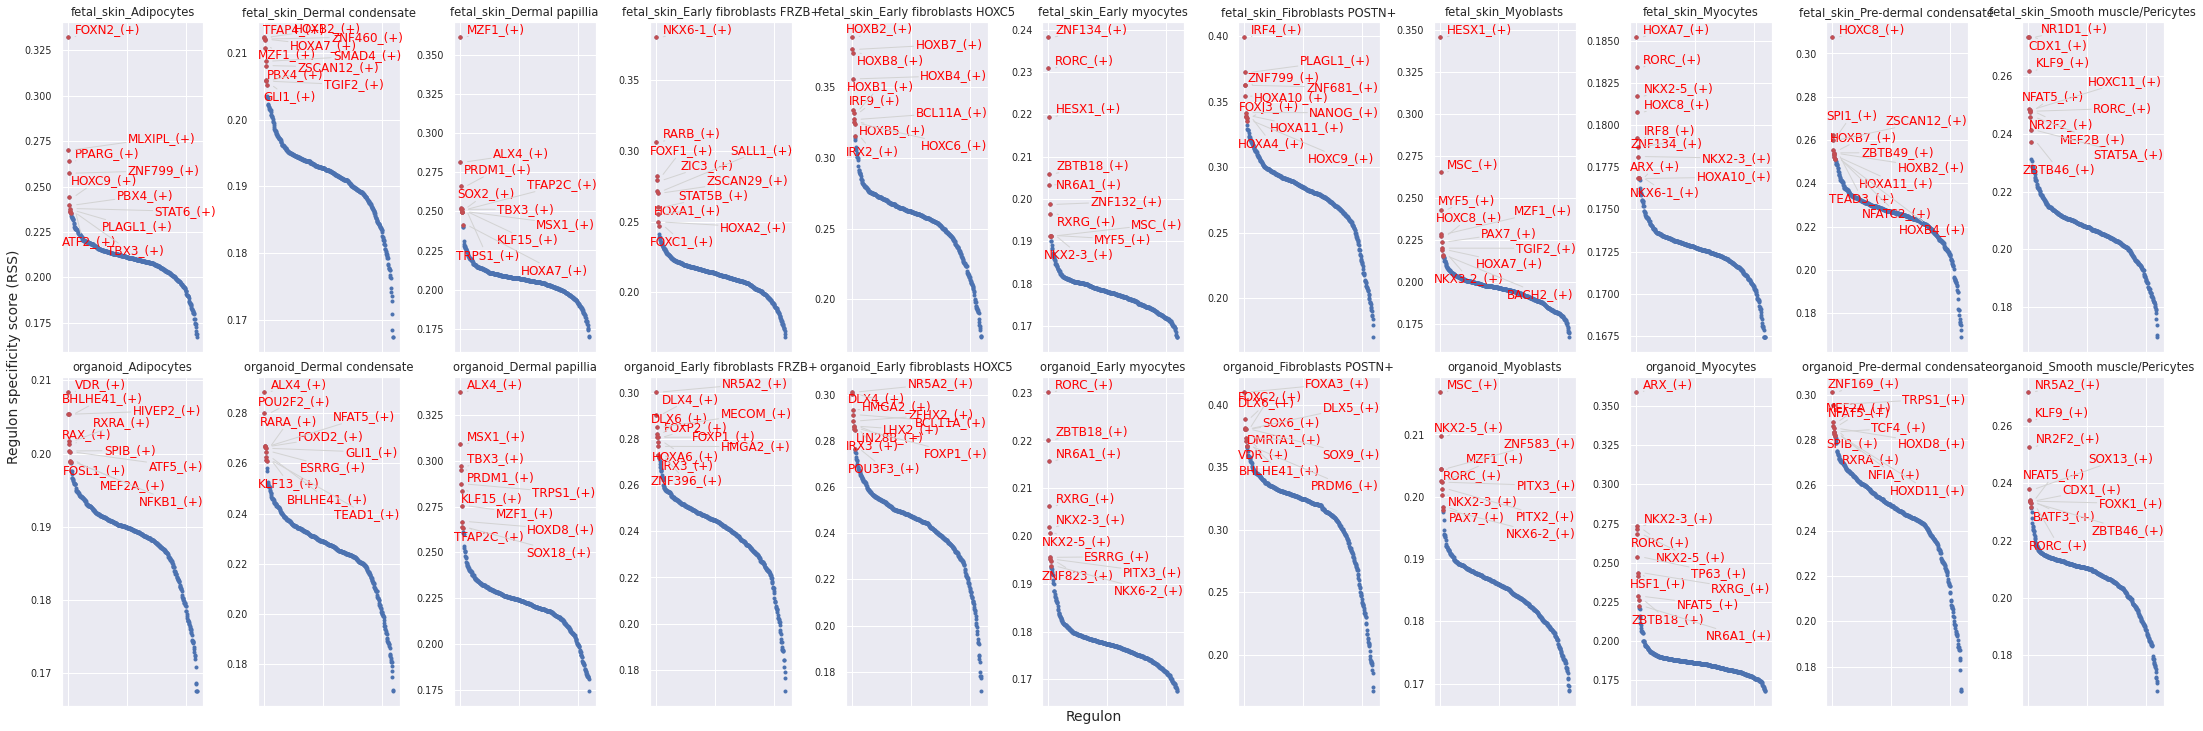

In [90]:
fig = plt.figure(figsize=(30, 10))
for i, c in enumerate(pooled_MS_ad.obs.source_joint_annot.cat.categories):
    num = i + 1
    x = pooled_MS_rss_sourceCellType.T[c]
    ax = fig.add_subplot(2, 11, num)
    plot_rss(pooled_MS_rss_sourceCellType, c, top_n=10, max_n=None, ax=ax)
    ax.set_ylim(x.min() - (x.max() - x.min()) * 0.05, x.max() + (x.max() - x.min()) * 0.05)
    for t in ax.texts:
        t.set_fontsize(12)
    ax.set_ylabel("")
    ax.set_xlabel("")
    adjust_text(
        ax.texts,
        autoalign="xy",
        ha="right",
        va="bottom",
        arrowprops=dict(arrowstyle="-", color="lightgrey"),
        precision=0.001,
    )

fig.text(0.5, 0.0, "Regulon", ha="center", va="center", size="x-large")
fig.text(
    0.00,
    0.5,
    "Regulon specificity score (RSS)",
    ha="center",
    va="center",
    rotation="vertical",
    size="x-large",
)
plt.tight_layout()
plt.rcParams.update(
    {
        "figure.autolayout": True,
        "figure.titlesize": "large",
        "axes.labelsize": "medium",
        "axes.titlesize": "large",
        "xtick.labelsize": "medium",
        "ytick.labelsize": "medium",
    }
)

In [99]:
celltypes = (
    pd.Series(pooled_MS_ad.obs.source_joint_annot.cat.categories).str.rpartition("_")[2].unique()
)

In [104]:
prog_intersect = []
for i, c in enumerate(celltypes):
    fsk_ct = f"fetal_skin_{c}"
    org_ct = f"organoid_{c}"
    fsk_prog = pooled_MS_rss_sourceCellType.T[fsk_ct].sort_values(ascending=False)[:10].index.values
    org_prog = pooled_MS_rss_sourceCellType.T[org_ct].sort_values(ascending=False)[:10].index.values
    N = len(set(list(fsk_prog) + list(org_prog)))
    n = len(set(list(fsk_prog)) & set(list(org_prog)))
    prog_intersect.append([c, n, N, n / N])

In [111]:
df1 = pd.DataFrame(prog_intersect, columns=["celltype", "n", "N", "jaccard"])

In [112]:
df1

,celltype,n,N,jaccard
0,Adipocytes,0,20,0.000000
1,Dermal condensate,1,19,0.052632
2,Dermal papillia,8,12,0.666667
3,Early fibroblasts FRZB+,0,20,0.000000
4,Early fibroblasts HOXC5,1,19,0.052632
5,Early myocytes,5,15,0.333333
6,Fibroblasts POSTN+,0,20,0.000000
7,Myoblasts,3,17,0.176471
8,Myocytes,4,16,0.250000
9,Pre-dermal condensate,0,20,0.000000


In [87]:
pooled_MS_topreg = []
for i, c in enumerate(pooled_MS_ad.obs.source_joint_annot.cat.categories):
    pooled_MS_topreg.extend(
        list(pooled_MS_rss_sourceCellType.T[c].sort_values(ascending=False)[:5].index)
    )
pooled_MS_topreg = list(set(pooled_MS_topreg))

In [88]:
pooled_MS_auc_mtx_Z = pd.DataFrame(index=pooled_MS_auc_mtx.index)
for col in list(pooled_MS_auc_mtx.columns):
    pooled_MS_auc_mtx_Z[col] = (
        pooled_MS_auc_mtx[col] - pooled_MS_auc_mtx[col].mean()
    ) / pooled_MS_auc_mtx[col].std(ddof=0)

In [93]:
colors = sns.color_palette(
    "bright", n_colors=pooled_MS_ad.obs.source_joint_annot.cat.categories.size
)
colorsd = dict(zip(pooled_MS_ad.obs.source_joint_annot.cat.categories, colors))
colormap = [colorsd[x] for x in pooled_MS_ad.obs.source_joint_annot]

/home/ubuntu/miniconda/envs/pyscenic/lib/python3.8/site-packages/seaborn/matrix.py:659: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.


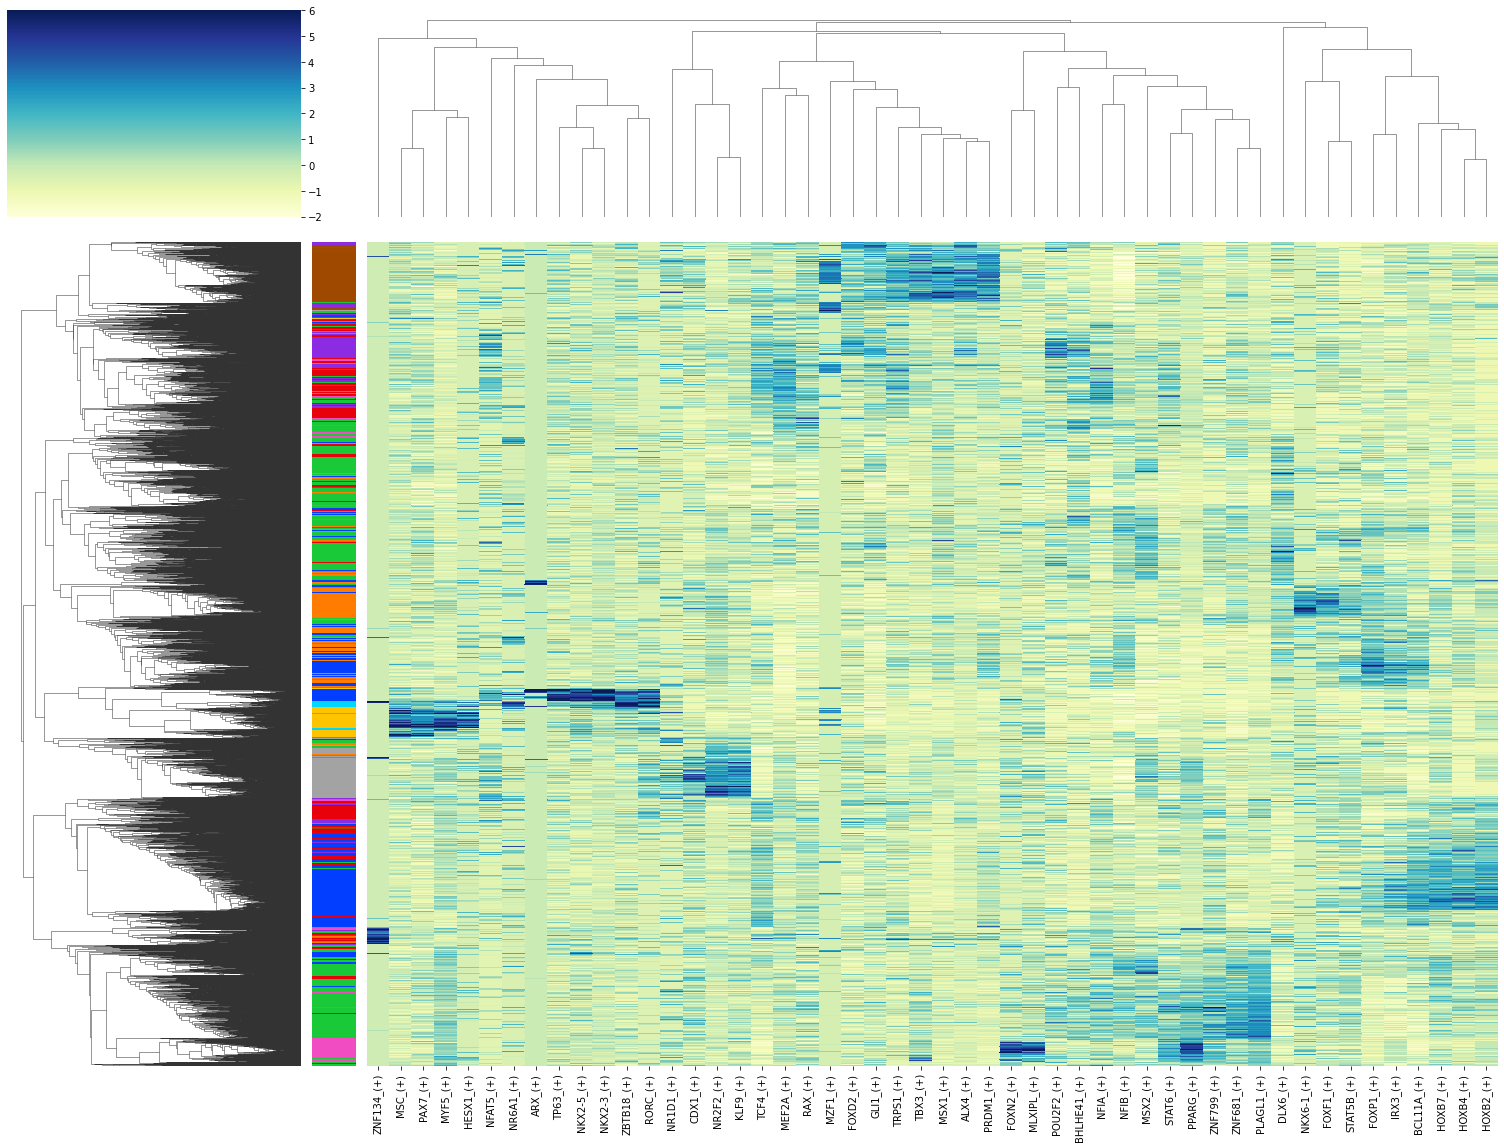

In [51]:
g = sns.clustermap(
    pooled_MS_auc_mtx_Z[pooled_MS_topreg],
    square=False,
    linecolor="gray",
    yticklabels=False,
    xticklabels=True,
    vmin=-2,
    vmax=6,
    row_colors=colormap,
    method="average",
    metric="cosine",
    cmap="YlGnBu",
    figsize=(21, 16),
)
g.cax.set_visible(True)
g.ax_heatmap.set_ylabel("")
g.ax_heatmap.set_xlabel("");

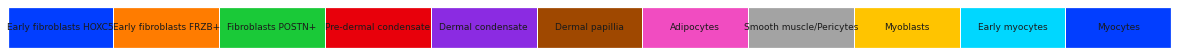

In [58]:
fig = palplot(colors, pooled_MS_ad.obs.joint_annot.cat.categories, size=1.5, fontsize=9)